In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
register_matplotlib_converters()

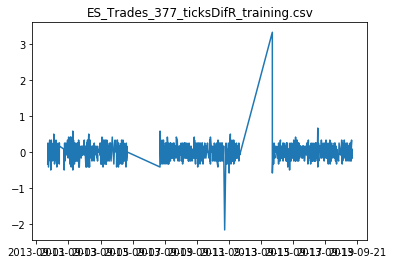

In [6]:
df_all = {}
for j in [377]:
    f=('ES_Trades_%d_ticksDifR_training.csv') %  (j)
    df_t = pd.read_csv(f,parse_dates=['DateTime'],infer_datetime_format=True,index_col='DateTime')
    df_all.update([('%d' % j,df_t)])
    plt.plot(df_t.index,df_t.mean(axis=1))
    plt.title(f)
    plt.show()

In [7]:
n_out=10
n_in=n_out*2
n_capa = 25
ep=200

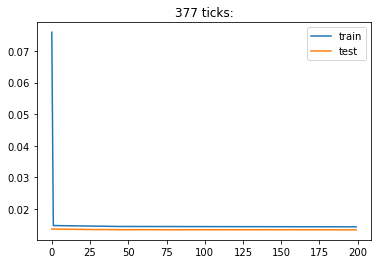

Test RMSE: 0.210


In [8]:
for j in [377]:
    df_t = df_all.get(str(j))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df_t)
    
    n_var=scaled.shape[1]
    reframe = series_to_supervised(scaled,n_in,n_out)
    values = reframe.values
    sep = round(0.7*len(values))
    x_n = n_var*n_in
    x_train, x_test, y_train, y_test = values[:sep,:x_n], values[sep:,:x_n], values[:sep,x_n:], values[sep:,x_n:]
    
    model = Sequential()
    model.add(Dense(n_capa,input_dim=(n_in*n_var),activation='relu'))#relu, rectificante lineal. sigmoid. tanh. softmax
    model.add(Dense(n_capa,activation='tanh'))
    model.add(Dense((n_out*n_var),activation='sigmoid'))
    model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mse'])
    
    history = model.fit(x_train,y_train,epochs=ep,validation_data=(x_test,y_test),batch_size=n_capa,verbose=0)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title(str(j)+" ticks:")
    plt.show()
    
    results = model.predict(x_test)
    results = results.reshape(len(x_test)*n_out,n_var)
    r_scale = scaler.inverse_transform(results)
    oy_test = scaler.inverse_transform(y_test.reshape(len(x_test)*n_out,n_var))
    rmse = rmse = sqrt(mean_squared_error(oy_test, r_scale))
    print('Test RMSE: %.3f' % rmse)

In [9]:
import pickle
pickle.dump(model,open("model.p","wb"))
pickle.dump(scaler,open("scaler.p","wb"))